<a href="https://colab.research.google.com/github/afk974/Deep-Learning/blob/main/Assessment1_DeepLearning_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessment 1: Deep Learning

1) Answer all questions.
2) This assessment is open-book. You are allowed to refer to any references including online materials, books, notes, codes, github links, etc.
3) Copy this notebook to your google drive (click **FILE** > **save a copy in Drive**)
4) Upload the answer notebook to your github. 
5) Submit the assessment by sharing the link to your answer notebook. 





**QUESTION 1** 

One day while wandering around a clothing store at KL East Mall, you stumbled upon a person who is choosing a dress for Hari Raya. It turns out that the person is visually impaired and had a hard time distinguishing between an abaya and a kebaya. To help people with the similar situation, you then decided to develop an AI system to identify the type of clothes using a Convolutional Neural Networks (ConvNet). In order to train the network, you decide to use the Fashion MNIST dataset which is freely available on Pytorch.


a) Given the problem, what is the most appropriate loss function to use? Justify your answer. **[5 marks]**


<span style="color:blue">
    ANSWER: Cross entropy loss function because it can calculate the performance for classification application using the output between 0 and 1.</span>

b) Create and train a ConvNet corresponding to the following CNN architecture (with a modification of the final layer to address the number of classes). Please include **[10 marks]**:

    1) The dataloader to load the train and test datasets.

    2) The model definition (either using sequential method OR pytorch class method).

    3) Define your training loop.

    4) Output the mean accuracy for the whole testing dataset.

    



![pic](https://raw.githubusercontent.com/CUTe-EmbeddedAI/images/main/images/LeNet.png)

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchsummary import summary


# 1) The dataloader to load the train and test datasets.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(32),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress',
       'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)


60000
10000


In [2]:
# 2) The model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.fc3(x)
        return x



In [3]:
model = CNN()

# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [4]:
# 3) Define your training loop.
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'fashion_model_'+str(epoch)+'.pt')
            
    return model, history


In [5]:
# Train the model for 10 epochs
num_epochs = 10
trained_model, history = train_and_validate(model, criterion, optimizer, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.8497, Accuracy: 70.0900%, 
		Validation : Loss : 0.4778, Accuracy: 82.2700%, Time: 48.1426s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.4156, Accuracy: 84.8900%, 
		Validation : Loss : 0.3912, Accuracy: 85.7100%, Time: 39.8241s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.3548, Accuracy: 86.8950%, 
		Validation : Loss : 0.3548, Accuracy: 87.1300%, Time: 42.0541s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.3223, Accuracy: 88.0467%, 
		Validation : Loss : 0.3662, Accuracy: 86.5700%, Time: 40.1079s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2993, Accuracy: 88.9933%, 
		Validation : Loss : 0.3332, Accuracy: 88.0800%, Time: 40.2180s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2824, Accuracy: 89.6317%, 
		Validation : Loss : 0.3247, Accuracy: 88.3500%, Time: 40.0640s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.2681, Accuracy: 90.0083%, 
		Validation : Loss : 0.3188, Accuracy: 88.6200%, Time: 40.5276s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.2556, Accura

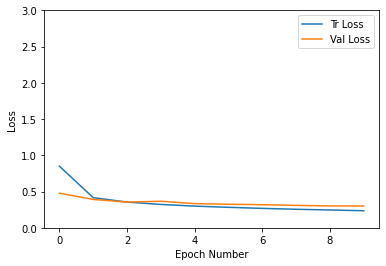

In [6]:
# 4) Output the mean accuracy for the whole testing dataset.

# Analyze the loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()


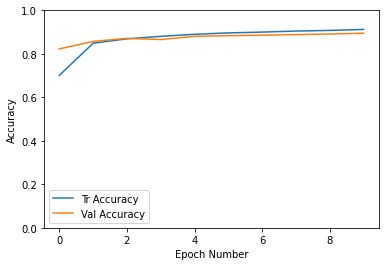

In [7]:
# Analyze the accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()

c) Replace your defined CNN in b) with a pre-trained model. Then, proceed with a transfer learning and finetune the model for the Fashion MNIST dataset. **[10 marks]**

In [13]:
model_ft = models.convnext_tiny(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

In [14]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.7196, Accuracy: 73.7483%, 
		Validation : Loss : 0.4046, Accuracy: 85.2900%, Time: 209.3894s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3261, Accuracy: 88.0067%, 
		Validation : Loss : 0.3129, Accuracy: 88.6200%, Time: 197.6347s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2648, Accuracy: 90.2550%, 
		Validation : Loss : 0.2754, Accuracy: 89.8600%, Time: 196.1009s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2241, Accuracy: 91.6750%, 
		Validation : Loss : 0.2850, Accuracy: 89.2000%, Time: 195.2243s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1957, Accuracy: 92.7933%, 
		Validation : Loss : 0.2465, Accuracy: 91.1800%, Time: 194.2015s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1711, Accuracy: 93.6050%, 
		Validation : Loss : 0.2633, Accuracy: 90.7300%, Time: 215.0794s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1495, Accuracy: 94.3867%, 
		Validation : Loss : 0.2463, Accuracy: 91.5600%, Time: 195.4873s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1283,

d) Using model-centric methods, propose two (2) strategies that can be used to increase the accuracy of the model on the testing dataset. **[5 marks]**


<span style="color:blue">
    Two model-centric techniques that I propose are: Changing the learning rate or use different pretrained model for the dataset.</span>

e) Next, implement the two proposed model-centric techniques for the same problem as in the previous question. **[15 marks]**

In [15]:
model_ft = models.googlenet(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [17]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.1523, Accuracy: 94.4967%, 
		Validation : Loss : 0.2255, Accuracy: 92.1100%, Time: 212.6750s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.1463, Accuracy: 94.6750%, 
		Validation : Loss : 0.2299, Accuracy: 91.8000%, Time: 206.1342s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.1347, Accuracy: 95.2783%, 
		Validation : Loss : 0.2639, Accuracy: 90.9100%, Time: 206.8019s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1308, Accuracy: 95.3000%, 
		Validation : Loss : 0.2379, Accuracy: 92.0300%, Time: 206.7181s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.1222, Accuracy: 95.5233%, 
		Validation : Loss : 0.2445, Accuracy: 91.9700%, Time: 208.8536s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1137, Accuracy: 95.9717%, 
		Validation : Loss : 0.2325, Accuracy: 92.2900%, Time: 206.1297s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1033, Accuracy: 96.3050%, 
		Validation : Loss : 0.2482, Accuracy: 92.0100%, Time: 207.4020s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1005,

f) Do you see any accuracy improvement? Whether it is a "yes" or "no", discuss the possible reasons contributing to the accuracy improvement/ unimprovement. **[5 marks]**

<span style="color:blue">
    Yes, there is a small improvement in the training and validation accuracy because the different model will have different weights for each layer which make the results will be different from each other while the learning rate can help to fine tune a bit to get a better result. </span>

g) In real applications, data-centric strategies are essential to train robust deep learning models. Give two (2) examples of such strategies and discuss how the strategies helps improving the model accuracy. **[5 marks]**

<span style="color:blue">
    Flip horizontally the image and rotate the image as the new image </span>

h) Next, implement the two proposed data-centric techniques for the same problem as in the previous question. **[10 marks]**

In [20]:
transforms = {
    transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],  [0.5, 0.5, 0.5])
    ]),

}


In [21]:
batch_size = 10

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress',
       'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

60000
10000


In [22]:
model_ft = models.googlenet(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
num_epochs = 10
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/10
Epoch : 000, Training: Loss: 0.7214, Accuracy: 77.2100%, 
		Validation : Loss : 0.4051, Accuracy: 85.2000%, Time: 208.9194s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3689, Accuracy: 87.3250%, 
		Validation : Loss : 0.3025, Accuracy: 89.6600%, Time: 207.6041s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2963, Accuracy: 89.5850%, 
		Validation : Loss : 0.2714, Accuracy: 90.5400%, Time: 205.4275s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.2628, Accuracy: 90.7000%, 
		Validation : Loss : 0.2575, Accuracy: 90.9500%, Time: 204.2032s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2373, Accuracy: 91.5633%, 
		Validation : Loss : 0.2486, Accuracy: 91.4100%, Time: 203.1594s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.2176, Accuracy: 92.3717%, 
		Validation : Loss : 0.3545, Accuracy: 87.2100%, Time: 203.3409s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.1994, Accuracy: 92.9283%, 
		Validation : Loss : 0.2299, Accuracy: 91.9200%, Time: 205.6661s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.1871,

**QUESTION 2** **[35 marks]**

Firstly, watch this video:

https://drive.google.com/file/d/1bsypahR7I3f_R3DXkfw_tf0BrbCHxE_O/view?usp=sharing

This video shows an example of masked face recognition where the deep learning model is able to detect and classify your face even when wearing a face mask. Using the end-to-end object detection pipeline that you have learned, develop your own masked face recognition such that the model should recognize your face even on face mask while recognize other persons as "others".

Deliverables for this question are:

- the model file. Change the name to <your_name>.pt file (e.g. hasan.pt).
- a short video (~10 secs) containing your face and your friends faces (for inference).

In [68]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 13553, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 13553 (delta 254), reused 308 (delta 212), pack-reused 13198
Receiving objects: 100% (13553/13553), 13.27 MiB | 31.60 MiB/s, done.
Resolving deltas: 100% (9313/9313), done.
/content/yolov5/yolov5
Setup complete. Using torch 1.12.1+cu113 (Tesla T4)


In [69]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [70]:
# set up environment
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [71]:
from roboflow import Roboflow
rf = Roboflow(api_key="7cYcdgNrmJLs7CGiH9fN")
project = rf.workspace("image-segmentation-u6vsb").project("face-detection-webiz")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/Face-Detection-1 in yolov5pytorch:: 100%|██████████| 686/686 [00:00<00:00, 2018.20it/s]


In [72]:
!python train.py --img 416 --batch 16 --epochs 150 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/Face-Detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hs

In [74]:
!python detect.py --weights runs/train/exp/weights/amjad.pt --img 416 --conf 0.1 --source 'C:\Users\User\Downloads\FaceTest\facetest.mp4'

detect: weights=['runs/train/exp/weights/amjad.pt'], source=C:\Users\User\Downloads\FaceTest\facetest.mp4, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Traceback (most recent call last):
  File "detect.py", line 258, in <module>
    main(opt)
  File "detect.py", line 253, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 108, i